**Calibration of spatial deterministic model** (focus on arrondissements)

Notes:
1. Based on calibration of national deterministic model found in ...
2. Includes Proximus mobility matrices that is updated every day
3. Includes three-fold stratified $\beta$ parameter (rural/urban/metropolitan)

# Load Python packages

In [107]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters #, sciensano, google
# from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import social_policy_func, ramp_fun, lockdown_func, policies_until_september

# Moving average for visualisation
from covid19model.visualization.utils import moving_avg

# Download function for complete calibration
# covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'arr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model parameter values
The model is supported by many parameters, which must be loaded into the model later on

In [108]:
# Interaction matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = \
    model_parameters.get_interaction_matrices(spatial=agg)

# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg)

# Add the social effect of the first lockdown
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})

# Load all hospitalisation data per arrondissement
The model is calibrated on daily new hospitalisations (`H_in`). This data is found in the nonpublic repository.

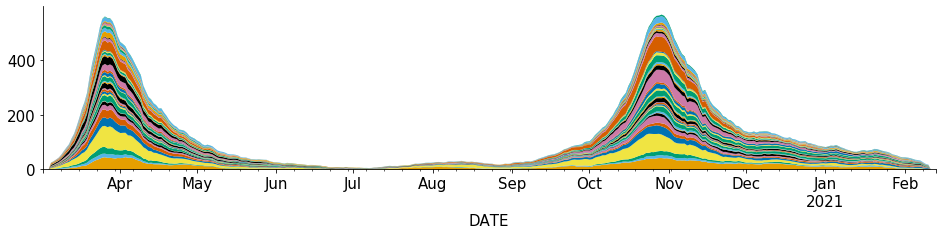

In [109]:
nonpublic_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_' + agg + '.csv'
nonpublic_ts = pd.read_csv(nonpublic_file, parse_dates=['DATE']).pivot_table(index='DATE', columns='NIS_' + agg, values='hospitalised_IN')

nonpublic_ts_avg = nonpublic_ts.copy()
for NIS in nonpublic_ts.columns:
    nonpublic_ts_avg[[NIS]] = moving_avg(nonpublic_ts[[NIS]])

# Show all 43 time series
fig, ax = plt.subplots(figsize=(16, 3))
nonpublic_ts_avg.plot(ax=ax,linewidth=0, kind='area')
ax.legend().remove()
ax.grid(False)

# Initialise model
The spatial model must have an initial condition

In [19]:
# Initial states: single 30 year old exposed individual in Brussels
initE = np.zeros(initN.shape)
initE[3,3] = 1
initial_states = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters={'Nc': lockdown_func}, spatial=agg)

In [45]:
from covid19model.models.time_dependant_parameter_fncs import

array([[0.92351913, 0.02508676, 0.00188085, 0.01017458, 0.0053895 ,
        0.01630184, 0.00300381, 0.00276325, 0.00903223, 0.00139263,
        0.00145542],
       [0.0277394 , 0.80663623, 0.013029  , 0.09242411, 0.0065618 ,
        0.02157711, 0.00885757, 0.00564503, 0.01206803, 0.00210998,
        0.00335173],
       [0.00415987, 0.03353376, 0.8211358 , 0.07536886, 0.00272749,
        0.00308014, 0.02612312, 0.01076919, 0.00177366, 0.00324923,
        0.01807889],
       [0.00570471, 0.04565463, 0.01437538, 0.90822647, 0.00260598,
        0.00480368, 0.00729868, 0.0046124 , 0.00160409, 0.00172737,
        0.0033866 ],
       [0.00792632, 0.00834021, 0.00148435, 0.00575054, 0.92089804,
        0.03541114, 0.01323393, 0.00205523, 0.00228337, 0.00110934,
        0.00150754],
       [0.02395819, 0.02134383, 0.00203319, 0.01809494, 0.02167882,
        0.89684921, 0.00759291, 0.00250675, 0.00272737, 0.00150521,
        0.00170957],
       [0.00311056, 0.01120625, 0.01614816, 0.01574838, 0.

# Scratches

In [53]:
data_location = '../../data/interim/mobility/arr/staytime/'
for idx, f in enumerate(os.listdir(data_location)):
    if idx == 0:
        data_file = pd.read_csv(data_location + f, index_col = 'mllp_postalcode')
    else:
        data_file += pd.read_csv(data_location + f, index_col = 'mllp_postalcode')
        
(data_file/(idx+1)).to_csv(f'../../data/interim/mobility/arr/quick-average_staytime_arr.csv')